# Recommender Engine using a "One Shot Learning Approach"

In [1]:
# !python -m spacy download en_core_web_trf

In [2]:
# !pip install cleantext

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import nltk
import pickle
import cleantext

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# Similarities & Distances
from sklearn.metrics import pairwise
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Visualizations
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

## Recommender Functions
___

In [4]:
def recommend_posts(train_vectors, test_vectors):
    # Find cosine distances between input and training data
    dists = pairwise.cosine_distances(train_vectors, test_vectors)

    # Organize distances between train and corpus in dataframe
    dists_df = pd.DataFrame(dists, index=postings.index)

    # Create dataframe for top job matches
    # Limit to 10 jobs for faster processing
    results_df = pd.DataFrame(dists_df[0].sort_values()[1:11])

    # Merge results with job postings on shared indices for job title and description
    output_df = results_df.merge(postings, left_index=True, right_index=True)
    return output_df

In [5]:
def recommend_words(recommendations):  
    # For each pos tag
    pos_tags = {'Verbs':'VERB', 'Nouns':'NOUN', 'Adjectives':'ADJ', 'Other Terms':'X'}
    
    # Plot top 20 most similar words
    fdist = dict(FreqDist(word.lower() for word in word_tokenize(recommendations['pos_docs'].sum())))
    common_words = pd.DataFrame(fdist.values(), columns=['Frequency'], index=fdist.keys())
    
    # Get Parts of Speech tags for most similar words 
    tokens = [word_tokenize(word) for word in fdist.keys()]
    common_words['pos_tags'] = [nltk.pos_tag(token, tagset = "universal")[0][1] for idx, token in enumerate(tokens)]
    
    return common_words

## Read in train and test data
___
The `recommend_titles` function require two sparse matrices, so we will need to vectorize job posting data and any README file from the portfolio project.

In [6]:
# Dataframe with job posting data
postings = pd.read_csv('../data/postings/postings.csv', index_col='id')
postings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47915 entries, I0000 to M9066
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_title     47915 non-null  object
 1   job_docs      47915 non-null  object
 2   job_type      10000 non-null  object
 3   category      9118 non-null   object
 4   job_board     9310 non-null   object
 5   company_name  38845 non-null  object
 6   city          38599 non-null  object
 7   state         38432 non-null  object
 8   url           19067 non-null  object
 9   full_desc     47915 non-null  object
 10  pos_docs      47915 non-null  object
dtypes: object(11)
memory usage: 4.4+ MB


In [7]:
# Text file from another nlp portfolio project
with open('../data/test-README.txt', 'rb') as file:
    readme = file.read()
    
print(readme[:100])

b'# NLP Reddit Project\n___\nKate Crawford | US-DSI-1010 | 12.06.2022\n\n## Problem Statement\n___\nThe inte'


In [8]:
# Load in vectorized text data as a sparse matrix
with open('../data/pickles/X_tvec.pkl', 'rb') as p_in_matrix:
    train_vectors = pickle.load(p_in_matrix)

## Running the Recommender Engine
___

### Prepare test data

In [9]:
# Clean the input data
def apply_cleantext(x):
    return cleantext.clean(x,
                           clean_all=False, # Execute all cleaning operations
                           extra_spaces=True,  # Remove extra white spaces 
                           stemming=False,  # Stem the words
                           stopwords=True,  # Remove stop words
                           lowercase=True,  # Convert to lowercase
                           numbers=True,  # Remove all digits 
                           punct=True,  # Remove all punctuations
                           stp_lang='english'  # Language for stop words
                          )

readme = apply_cleantext(str(readme))

In [10]:
# Vectorize the input data
with open('../data/pickles/tvec.pkl', 'rb') as p_in_matrix:
    tvec = pickle.load(p_in_matrix)
# Import pipeline
test_vectors = tvec.transform([readme])

### Create Dataframes with recommendations

In [11]:
# Generate recommended job title
recommendations = recommend_posts(train_vectors, test_vectors)
recommendations['job_title']

id
M5735                                   legal counsel
I7377                                      counsel sr
I12185                      assistant general counsel
I17376                 software development team lead
I16595                    associate corporate counsel
I17451                              corporate counsel
I18219    associate vice president, corporate counsel
I6122                    contract technical recruiter
I20447                      assistant general counsel
M3671            business intelligence analyst, legal
Name: job_title, dtype: object

In [12]:
# Generate most frequently similar language by parts of speech
common_words = recommend_words(recommendations)
common_words

,Frequency,pos_tags
legal,158,ADJ
counsel,29,NOUN
smartphone,1,NOUN
user,9,NOUN
part,1,NOUN
...,...,...
metric,1,ADJ
cultivate,1,NOUN
accept,1,NOUN
proud,1,NOUN


### Format outputs that provide insights for each recommended job.

In [13]:
def create_cards(recommendations):
    rec_columns = ['job_title', 'city', 'state']
    output = {}
    
    for index in range(len(recommendations)):
        insights = []
        # Return information about recommended job
        for column in rec_columns:
            # if there is no information go to the next columns
            if pd.isnull(recommendations[column].iloc[index]) == True:
                continue
            # else add information to the list
            else:
                insights.append(recommendations[column].iloc[index])
                
        # Generate Link to LinkedIn        
        base_url = "https://www.linkedin.com/jobs/search/?"
        keywords = f"keywords={recommendations['job_title'][index].replace(' ','%20')}"
        # If there is a city and state given
        if pd.isnull(recommendations['city'][index]) == False and pd.isnull(recommendations['state'][index]) == False:
            location = f"location={recommendations['city'][index].replace(' ', '%20')}"
            insights.append(base_url + keywords + '&' + location)
        else: 
            insights.append(base_url + keywords)
            
        output[index] = insights
        
    return output

In [14]:
def display_cards(job_cards):
    displays = []
    for card in job_cards.values():
        insights = []
        for insight in card:
            display_insight = ''
            for word in insight.split(' '):
                display_insight += word[0].upper() + word[1:] + ' '
            insights.append(f'{display_insight}\n')
        displays.append(insights)
    return displays

In [15]:
job_cards = create_cards(recommendations)

In [16]:
displays = display_cards(job_cards)
for i in displays:
    print(i)
    print()

['Legal Counsel \n', 'Https://www.linkedin.com/jobs/search/?keywords=legal%20counsel \n']

['Counsel Sr \n', 'Philadelphia \n', 'PA \n', 'Https://www.linkedin.com/jobs/search/?keywords=counsel%20sr&location=Philadelphia \n']

['Assistant General Counsel \n', 'Cambridge \n', 'MA \n', 'Https://www.linkedin.com/jobs/search/?keywords=assistant%20general%20counsel&location=Cambridge \n']

['Software Development Team Lead \n', 'Austin \n', 'TX \n', 'Https://www.linkedin.com/jobs/search/?keywords=software%20development%20team%20lead&location=Austin \n']

['Associate Corporate Counsel \n', 'New York \n', 'NY \n', 'Https://www.linkedin.com/jobs/search/?keywords=associate%20corporate%20counsel&location=New%20York \n']

['Corporate Counsel \n', 'East Syracuse \n', 'NY \n', 'Https://www.linkedin.com/jobs/search/?keywords=corporate%20counsel&location=East%20Syracuse \n']

['Associate Vice President, Corporate Counsel \n', 'Irvine \n', 'CA \n', 'Https://www.linkedin.com/jobs/search/?keywords=associa

### Provide insights into how the recommendations were selected by returning the most frequent and similar terms found in the project readme file and each job description.

In [17]:
def plot_pos(common_words):    
    pos_tags = {'Adjectives':'ADJ', 'Nouns':'NOUN', 'Verbs':'VERB'}
    tag_plots = {}
    for name, tag in pos_tags.items():
        plot = common_words.loc[common_words['pos_tags'] == tag].sort_values('Frequency', ascending=False)[:10]
        fig = px.bar(plot, x='Frequency', y=plot.index, title=f"Relevant {name}")
        tag_plots[name] = fig
    return tag_plots

In [18]:
tags = plot_pos(common_words)

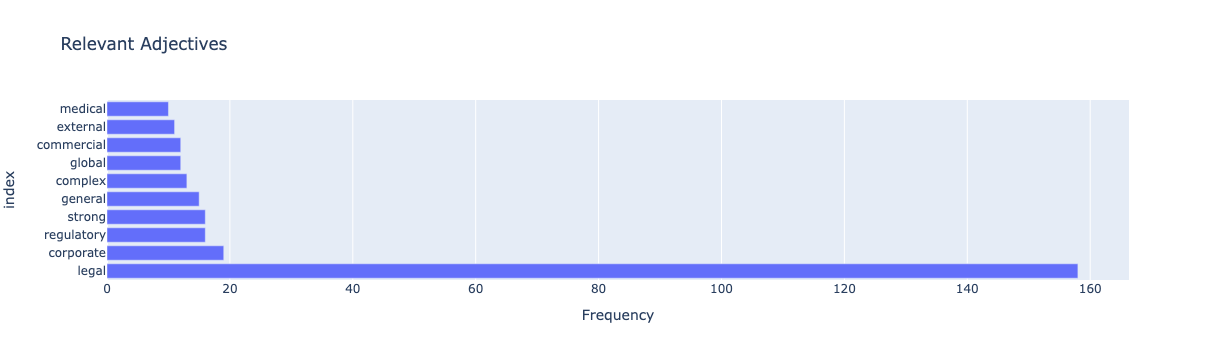

In [19]:
tags['Adjectives']

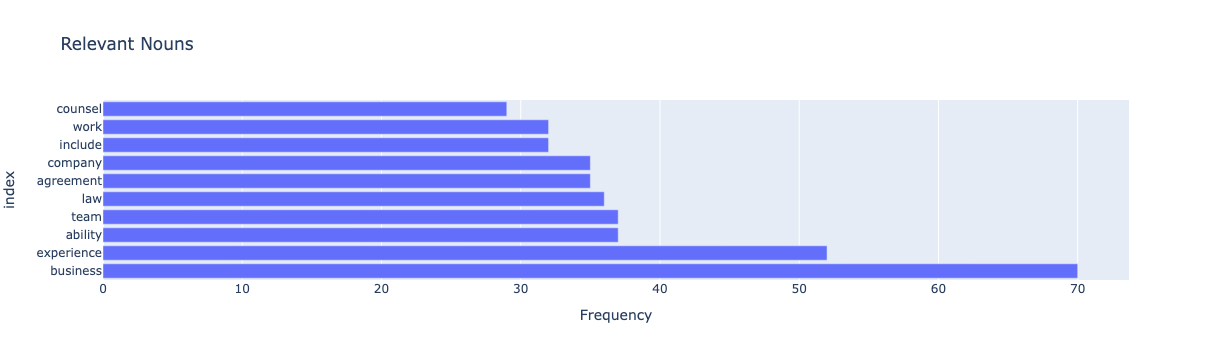

In [20]:
tags['Nouns']

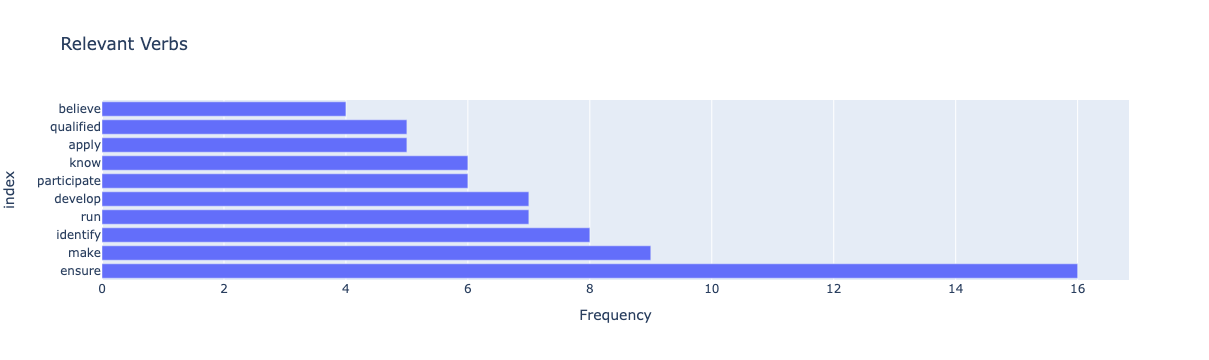

In [21]:
tags['Verbs']

## Conclusions & Recommendations